Many MCMC algorithms perform poorly in high dimensions as they rely on a form of random searches based on local perturbations. Hamiltonian Monte Carlo (HMC), however, leverages gradient information to guide the local moves and propose new states. The gradients of the log probability of the posterior evaluated at some state provides information of the geometry of the posterior density function. HMC attempts to avoid the random walk behavior typical of Metropolis-Hastings by using the gradient to propose new positions far from the current one with high acceptance probability. This allows HMC to scale to higher dimensions and in principle more complex posterior geometries. 

### Hamiltonian Mechanics in a Statistical Setting

HMC gets its name from Hamiltonian mechanics. The field of mechanics can be used to describe simple systems such as a bouncing ball, a pendulum or an oscillating spring in which energy changes from kinetic to potential and back again over time. Consider a skateboarder riding in an empty pool. We can characterize the skateboarder in terms of their position $\theta \in \mathbb{R}^D$ denoted $q$ and momentum $v \in \mathbb{R}^D$, denoted $p$. The set of all possible values for ($q, p$) the skateboarder can take on is called the **phase space**. The Hamiltonian function is a description of the total energy of a physical system and is defined as:

$$\mathcal{H}(q, p) = \mathcal{E}(q) + \mathcal{K}(p)$$

where $\mathcal{E}(q)$ is the **potential energy**, and $\mathcal{K}(p)$ is the **kinetic energy**. $\mathcal{H}(q, p)$ is the **total energy**. However, since we are operating in a statistical, not a physical, setting, the potential energy is a log probability density function (logpdf) such as $p(q, D)$:

$$\mathcal{E}(q) = -log\tilde{p}(q)$$

and kinetic energy is:

$$\mathcal{K} = \frac{1}{2}p^T\sum^{-1}p$$

where $\sum$ is a positive-definite matrix, known as the inverse mass matrix. Why is kinetic energy this way? We are free to choose the kinetic energy, and if we choose it to be Gaussian, and drop the normalization constant, we get the $\mathcal{K}$ above.

To run the physics simulation, one must solve the continuous time differential equations, known as Hamilton's equations:

$$\frac{dq}{dt} = \frac{\partial \mathcal{H}}{\partial p} = \frac{\partial \mathcal{K}}{\partial p}$$

$$\frac{dp}{dt} = -\frac{\partial \mathcal{H}}{\partial q} = -\frac{\partial \mathcal{E}}{\partial q}$$

#### Conservation of Energy

Since we are running a physics simulation, total energy must be conserved. Intuitively, a satellite in orbit around a planet will "want"  to continue in a straight line due to its momentum, but will get pulled in towards the planet due to gravity, and if these forces cancel out, the orbit is stable. If the satellite beings spiraling towards the planet, its kinetic energy will increase but its potential energy will decrease. In our statistical setting, if total energy is not conserved, then this means there were _divergences_ and our numerical approximation went bad. 

### Leapfrog Integrator

To simulate the differential equations above, we must first discretize $t$, and go back and forth updating $q$ and $p$. However, this "back and forth" is not so straightforward. It turns out, one way to simulate Hamiltonian dynamics, is with a method called the **leapfrog integrator**. 

This integrator first performs a half update of the momentum $p$, then a full update of the position $q$, and then finally another half update of the momentum. 

$$\underbrace{v_{t+1/2} = v_t - \frac{\eta}{2} \frac{\partial \mathcal{E}(q_t)}{\partial q}}_{\text{half update}}$$

$$\underbrace{q_{t+1} = q_t + \eta \frac{\partial \mathcal{K}(p_{t+1/2})}{\partial p}}_{\text{full update}}$$

$$\underbrace{v_{t+1} = v_{t+1/2} - \frac{\eta}{2} \frac{\partial \mathcal{E}(q_{t+1})}{\partial q}}_{\text{half update}}$$


The leapfrog integrator has two important parameters: (1) path length, and (2) step size $\eta$. In the simululation, the path length represents how "long" you travel before collecting another sample. The step size indicates the size each step is in the path length and determines how fine grained the simulation is. For example, in the drawing below, imagine path length $=1$ for both simulations. However, the left simulation has a step size $=4$ whereas the right simulation has a step size $=2$. These parameters are important in determining how the simulator collects samples of the geometry of the posterior.

![leapfrog](leapfrog_params.png)

### Main Idea

HMC says the log posterior is like a "bowl" (the empty pool in the figure below), with the highest posterior probability at the center of the valley. If we give the skateboarder a flick, this momentum will simulate its path. It must obey physics, gliding along until we stop the clock and take a sample. If the log posterior is flat, then not much information is in the likelihood & prior and the skateboarder will glide before the gradient makes it turn around. However, if the geometry of the log posterior is not flat, like the pool below, the gradient will make the skateboarder turn around and back into the valley. Since HMC runs a physics simulation, certain things must be conserved, i.e., the total energy of the system. 

![skateboarder](skateboarder.jpeg)

HMC needs a few things to run:
1. A function or callable that returns the negative log probability of the data at the current position $q$
2. A means of returning the gradient of the negative log probability at the current position $q$
3. An integrator for simulating the Hamiltonian equations in discrete time with two parameters:
    - step size 
    - path length

The algorithm for running HMC is to: set the initial position $q$ to $q'_0 = q_{t-1}$, and sample a new random momentum $p' \sim \mathcal{N}(0, \sum)$. Then, initialize a random trajectory in the phase space, starting at ($q'_0, p'_0$), followed for $L$ leapfrog steps until we get to the new proposed state ($q^*, p^*$) $=$ ($q'_L, p'_L$). With the new proposed state, we compute the MH acceptance probability. This process is ran $n$ times, according the number of samples the user wants to collect.

### Hamiltonian Monte Carlo - Multivariate Normal

The HMC implementation below is heavily inspired by Colin Carroll's [implementation](https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/). I recommend reading his blog plosts on HMC for an in-depth, but intuitive, explanation.

In [1]:
#| echo: false
import numpy as np
import torch
from torch import distributions as dist
import matplotlib.pyplot as plt
import argparse
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore") # ignore matlotlib

In [6]:
#| code-fold: true
def log_probs_to_img(dist, extent=None, num=100):

    if extent is None:
        extent = (-3, 3, -3, 3)

    X, Y = torch.meshgrid(
        torch.linspace(*extent[:2], num), torch.linspace(*extent[2:], num)
        )

    Z = torch.dstack((X, Y))
    log_probs = torch.exp(dist.log_prob(Z))
    
    return X, Y, log_probs, extent


def plot_hmc(X, Y, Z, samples, positions, momentum, extent):

    collected_samples = np.vstack([tens.detach().numpy() for tens in samples])
    leap_q = [[tens.detach().numpy() for tens in q] for q in positions]
    leap_p = [[tens.detach().numpy() for tens in p] for p in momentum]

    final_q = np.concatenate(leap_q)
    final_p = np.concatenate(leap_p)

    steps = slice(None, None, 20)

    plt.figure(figsize=(10, 6))
    plt.contourf(X, Y, Z, extent=extent, levels=20)
    plt.quiver(
        final_q[steps, 0], final_q[steps, 1], final_p[steps, 0], final_p[steps, 1], 
        headwidth=5, scale=80, headlength=7
        )
    plt.plot(final_q[:, 0], final_q[:, 1], linestyle='-', lw=2.5, color='black')
    plt.scatter(
        collected_samples[:, 0], collected_samples[:, 1],
        color='red', alpha=0.75
        )

    plt.title('Hamiltonian Monte Carlo')
    plt.show()

In [7]:
def leapfrog(q, p, dist, path_len, step_size):
    
    output = -dist.log_prob(q)
    output.backward()
    p -= step_size * q.grad / 2
    q.grad.zero_()

    leap_q = []
    leap_p = []
    for _ in range(int(path_len / step_size) - 1):

        q.grad.zero_()
        with torch.no_grad():
            q += step_size * p
        output = -dist.log_prob(q)
        output.backward()
        p -= step_size * q.grad

        leap_q.append(q.clone())
        leap_p.append(p.clone())
        
    output = -dist.log_prob(q)
    output.backward()
    
    with torch.no_grad():
        q += step_size * p
    
    p -= step_size * q.grad / 2

    return q, -p, leap_q, leap_p

In [8]:
def hamiltonian_monte_carlo(
    n_samples, 
    dist, 
    initial_position,
    path_len=1, 
    step_size=0.1
    ):
    """

    This HMC implementation is inspired by Colin Carroll's blog post:
    https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/

    Parameters:
    ----------
    n_samples : int
        Number of samples to return
    dist : object
        PyTorch distribution object that can be called
    initial_position : np.array
        A place to start sampling from.
    path_len : float
        How long each integration path is. Smaller is faster and more correlated.
    step_size : float
        How long each integration step is. Smaller is slower and more accurate.

    Returns:
    -------
    param_samples: list
        list of parameter samples (position q)
    all_leap_q: list
        list of all the positions (q) when leapfrog integrator is ran
    all_leap_p: list
        list of all the momentum (p) values when leapfrog integrator is ran
    """    

    samples = [initial_position]
    param_samples = []
    all_leap_q = []
    all_leap_p = []

    momentum = torch.distributions.Normal(0, 1)

    size = (n_samples,) + initial_position.shape[:1]
    for idx, p0 in tqdm(enumerate(momentum.sample(size)), total=size[0]):

        q0 = samples[-1]
        q_new, p_new, leap_q, leap_p = leapfrog(
            q=q0,
            p=p0,
            dist=dist,
            path_len=2 * np.random.rand() * path_len,
            step_size=step_size
            )

        all_leap_q.append(leap_q)
        all_leap_p.append(leap_p)

        # Metropolis acceptance criterion
        start_log_p = torch.sum(momentum.log_prob(p0)) - dist.log_prob(samples[-1])
        new_log_p = torch.sum(momentum.log_prob(p_new)) - dist.log_prob(q_new)
        p_accept = min(1, torch.exp(new_log_p - start_log_p))

        if torch.rand(1) < p_accept:
            param_samples.append(q_new.clone())
        else:
            param_samples.append(q0.clone())
        
    return param_samples, all_leap_q, all_leap_p

In [9]:
def main(args):

    mvn = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))
    init_pos = torch.randn(2, requires_grad=True)

    X, Y, Z, extent = log_probs_to_img(mvn, (-3, 3, -3, 3), num=200)

    samples, leap_q, leap_p = hamiltonian_monte_carlo(
        n_samples=args.n_samples,
        dist=mvn,
        initial_position=init_pos,
        path_len=args.path_len,
        step_size=args.step_size
        )

    plot_hmc(X, Y, Z, samples, leap_q, leap_p, extent)

100%|██████████| 10/10 [00:00<00:00, 62.54it/s]


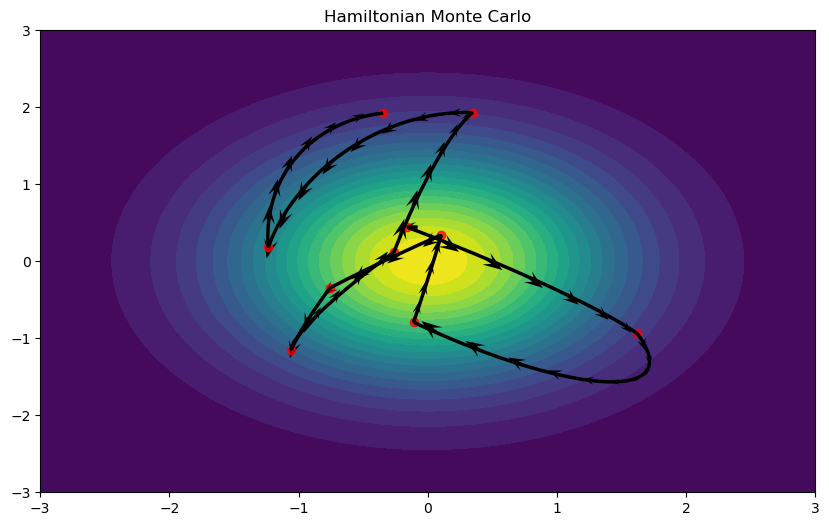

In [15]:
parser = argparse.ArgumentParser(description='HMC')
parser.add_argument('--n_samples', type=int, default=10)
parser.add_argument('--path_len', type=int, default=1)
parser.add_argument('--step_size', type=float, default=0.01)
args = parser.parse_args("")

main(args)